# 이미지 필터링
이미지 필터링은 여러 수식을 이용하여 이미지를 이루고 있는 픽셀 행렬을 다른 값으로 바꾸어 이미지를 변형하는 것을 말한다.

### 임계처리
임계처리(thresholding)는 이미지 행렬에서 하나의 픽셀값을 사용자가 지정한 기준값(threshold)를 사용하여 이진화(binarization)하는 가장 단순한 필터다. OpenCV에서는 `threshold`라는 함수로 구현되어 있다.
- threshold(src, thresh, maxval, type)
    - src: 그레이 스케일 이미지
    - thresh: 기준값
    - maxval: 기준값을 넘었을 때 적용할 최대값
    - type: 임계처리 유형
        - THRESH_BINARY: 기준값을 넘으면 최대값 아니면 0
        - THRESH_BINARY_INV: 기준값을 넘으면 0 아니면 최대값
        - THRESH_TRUNC: 기준값을 넘으면 기준값 아니면 최대값
        - THRESH_TOZERO: 기준값을 넘으면 원래값 아니면 0
        - THRESH_TOZERO_INV: 기준값을 넘으면 0 아니면 원래값

각 임계유형의 결과를 시각화하면 다음과 같다.

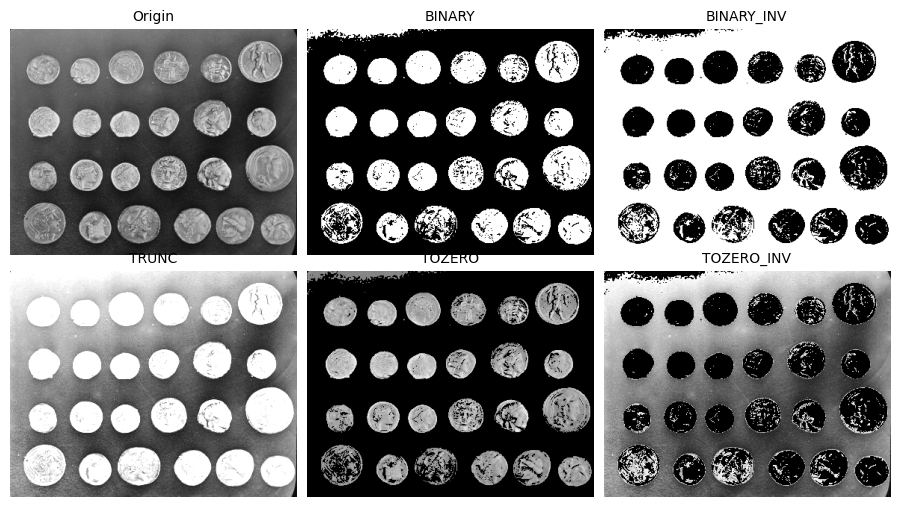

In [5]:
import cv2
from skimage.data import coins
import matplotlib.pyplot as plt

img = coins()

maxval = 255
thresh = maxval / 2

_, thresh1 = cv2.threshold(img, thresh, maxval, cv2.THRESH_BINARY)
_, thresh2 = cv2.threshold(img, thresh, maxval, cv2.THRESH_BINARY_INV)
_, thresh3 = cv2.threshold(img, thresh, maxval, cv2.THRESH_TRUNC)
_, thresh4 = cv2.threshold(img, thresh, maxval, cv2.THRESH_TOZERO)
_, thresh5 = cv2.threshold(img, thresh, maxval, cv2.THRESH_TOZERO_INV)

titles = ["Origin", "BINARY", "BINARY_INV", "TRUNC", "TOZERO", "TOZERO_INV"]
images = [img, thresh1, thresh2, thresh3, thresh4, thresh5]

plt.figure(figsize=(9, 5))
for i in range(6):
    plt.subplot(2, 3, i+1), plt.imshow(images[i], cmap="gray")
    plt.title(titles[i], fontdict={"fontsize": 10})
    plt.axis("off")

plt.tight_layout(pad=0.7)
plt.show()

### 적응임계처리
임계처리의 경우는 이미지 전체에 하나의 기준값을 적용한다. 적응임계처리는 일정한 영역 내의 이웃한 픽셀들의 값들을 이용하여 해당 영역에 적용할 기준값을 자체적으로 계산한다. OpenCV에서는 adaptiveThreshold 함수로 구현되어 있다.
- adaptiveThreshold(src, maxValue, adaptiveMethod, thresholdType, blockSize, C)
    - src: 그레이 스케일 이미지
    - maxValue: 기준값을 넘었을 때 적용할 값
    - adaptiveMethod: 영역 내에서 기준값을 계산하는 방법.
        - ADAPTIVE_THRESH_MEAN_C: 영역 내의 평균값에 C를 뺀 값을 기준값으로 사용
        - ADAPTIVE_THRESH_GAUSSIAN_C: 가우시안 블러를 적용한 후 C를 뺀 값을 기준값으로 사용
    - thresholdType: 임계처리 유형
        - THRESH_BINARY
        - THRESH_BINARY_INV
    - blockSize: 임계처리를 적용할 영역의 크기
    - C: 평균이나 가중평균에서 차감할 값

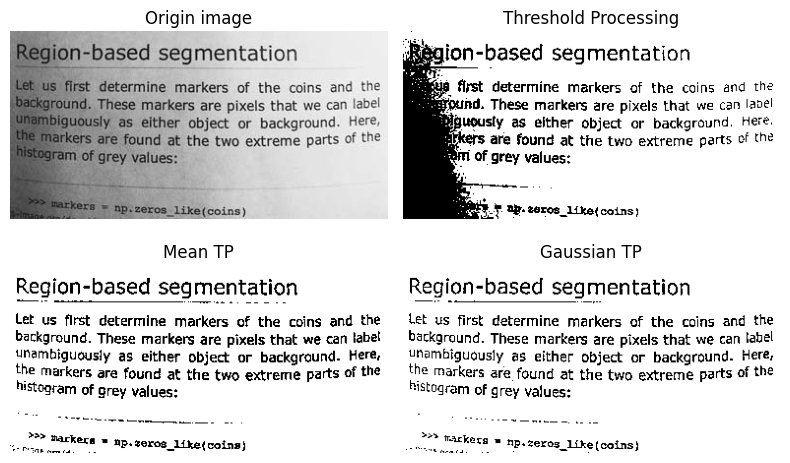

In [17]:
from skimage.data import page

img = page()

maxval = 255
thresh = 126
ret, th1 = cv2.threshold(img, thresh, maxval, cv2.THRESH_BINARY)

k = 15
C = 20

th2 = cv2.adaptiveThreshold(img, maxval, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, k, C)
th3 = cv2.adaptiveThreshold(img, maxval, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, k, C)

images = [img, th1, th2, th3]
titles = ["Origin image", "Threshold Processing", "Mean TP", "Gaussian TP"]

plt.figure(figsize=(8, 5))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(images[i], cmap="gray")
    plt.title(titles[i])
    plt.axis("off")

plt.tight_layout()
plt.show()

### 이미지 필터링
이미지 필터링은 필터 또는 커널 또는 윈도우라고 하는 정방행렬을 정의하고 이 커널을 이동시키면서 같은 이미지 영역과 곱하여 그 결과값을 이미지의 해당 위치의 값으로 하는 새로운 이미지를 만드는 연산이다. 기호 ⊗로 표기한다.

원본 이미지의 (x, y)위치의 명도를 f(x,y), 필터 이미지를 h(x,y), 필터링된 결과를 g(x, y)라고 하면 수식으로 다음과 같다.  
$f \otimes h = \sum\limits_{u=-K/2}^{K} f(x+u, y+v)\cdot h(u,v)$  
이 식에서 K는 필터 크기의 절반을 뜻한다. 예를 들어 3x3 크기의 필터에서는 K=1 이다. 위 식을 줄여서 다음처럼 나타내기도 한다. WS는 윈도우 영역을 뜻한다.  
$f \otimes h = \sum\limits_{W} f(x+u, y+v)\cdot h(u,v)$  
위 식에서 필터를 좌우 상하로 뒤집으면 콘볼루션(convolution)이라고 한다. 기호 *로 표시한다.  
$f * h = f \otimes h^{\sim} = \sum\limits_{W} f(x+u, y+v)\cdot h^{\sim}(u,v)$  
$h^{\sim}(u,v) = h(-u,-v)$  

### 윈도우 연산
OpenCV에서는 filter2D 함수를 사용한다.

filter2D(src, ddepth, kernel[, dst[, anchor[, delta[, borderType]]]])
- src: 이미지
- ddepth: 이미지 깊이(자료형 크기). -1이면 입력과 동일
- kernel: 커널 행렬

다음 코드는 평균을 구하는 커널 적용한 예다. 커널 크기가 커지면서 이미지가 점점 더 흐려지는 것을 볼 수 있다.

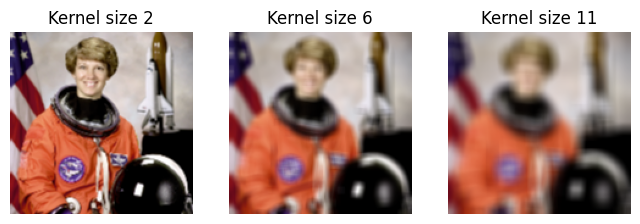

In [18]:
import cv2
from skimage.data import astronaut
import numpy as np

img = astronaut()
img = cv2.resize(img, dsize=(150, 150))
plt.figure(figsize=(8, 3))
for i, k in enumerate([2, 6, 11]):
    kernel = np.ones((k, k)) / k**2
    filtering = cv2.filter2D(img, -1, kernel)
    plt.subplot(1, 3, i + 1)
    plt.imshow(filtering)
    plt.title("Kernel size {}".format(k))
    plt.axis("off")
plt.show()